In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
from pandas import (
    read_sql_query, 
    DataFrame,
    ExcelWriter,
    options
)
from dataframe_image import export


from enum import Enum
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class Period(Enum):
    date = '2022-04-01'
    week='2022-07-10'
    date_du_jour = datetime.today().strftime("%d_%m_%Y")

In [3]:
load_dotenv()
# get the environment variables needed
USER = config('USRCaris')
PASSWORD = config('PASSCaris')
HOSTNAME = config('HOSTCaris')
DBNAME = config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(
    f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")



True

In [4]:
query_presenceQty = f'''
SELECT 
    a.*, COUNT(*) AS qte_pres_by_creator
FROM
    (SELECT 
            dgs.created_by,
            au.email AS email,
            au.username
    FROM
        caris_db.dream_group_session dgs
    LEFT JOIN dream_group_attendance dga ON dgs.id = dga.id_group_session
    LEFT JOIN dream_group dg ON dgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dgs.created_by
    WHERE
        dga.value = 'P'
            AND dgs.date >= '{Period.date.value}') a
GROUP BY a.created_by
'''

query_beneficiariesQty = f'''
SELECT *, COUNT(*) AS qte_by_creator FROM
    (SELECT
        dgs.id AS id_session,
            topic,
            date,
            dga.id_patient AS id_patient,
            dgs.created_by,
            lc.name AS commune,
            ld.name AS departement,
            dh.name AS hub,
            au.email AS email,
            au.username,
            b.first_name,
            b.last_name,
            p.patient_code as dreams_code
    FROM
        caris_db.dream_group_session dgs
    INNER JOIN dream_group_attendance dga ON dgs.id = dga.id_group_session
        LEFT JOIN dream_group dg ON dgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dgs.created_by
    left join beneficiary b on dga.id_patient=b.id_patient
    left join patient p on p.id=dga.id_patient
    WHERE
        dga.value = 'P'
            AND dgs.date >= '{Period.date.value}') a
            group by a.id_patient, a.username
'''


In [5]:
query_presenceWeek = f'''
SELECT 
    a.*, COUNT(*) AS qte_pres_by_creator
FROM
    (SELECT 
            dgs.created_by,
            au.email AS email,
            au.username
    FROM
        caris_db.dream_group_session dgs
    LEFT JOIN dream_group_attendance dga ON dgs.id = dga.id_group_session
    LEFT JOIN dream_group dg ON dgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dgs.created_by
    WHERE
        dga.value = 'P'
            AND dgs.date >= '{Period.week.value}') a
GROUP BY a.created_by
'''

query_beneficiariesWeek = f'''
SELECT *, COUNT(*) AS qte_by_creator FROM
    (SELECT
        dgs.id AS id_session,
            topic,
            date,
            dga.id_patient AS id_patient,
            dgs.created_by,
            lc.name AS commune,
            ld.name AS departement,
            dh.name AS hub,
            au.email AS email,
            au.username,
            b.first_name,
            b.last_name,
            p.patient_code as dreams_code
    FROM
        caris_db.dream_group_session dgs
    INNER JOIN dream_group_attendance dga ON dgs.id = dga.id_group_session
        LEFT JOIN dream_group dg ON dgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dgs.created_by
    left join beneficiary b on dga.id_patient=b.id_patient
    left join patient p on p.id=dga.id_patient
    WHERE
        dga.value = 'P'
            AND dgs.date >= '{Period.week.value}') a
            group by a.id_patient, a.username
'''


In [6]:
query_parentingBene = f'''
SELECT 
    *, COUNT(*) AS qte_by_creator
FROM
    (SELECT 
        dpgs.id_group AS id_session,
            topic,
            date,
            dpga.id_patient AS id_patient,
            dpgs.created_by,
            lc.name AS commune,
            ld.name AS departement,
            dh.name AS hub,
            au.email AS email,
            au.username,
            b.first_name,
            b.last_name,
            p.patient_code AS dreams_code
    FROM
        caris_db.dream_parenting_group_session dpgs
    LEFT JOIN dream_parenting_group_attendance dpga ON dpgs.id = dpga.id_parenting_group_session
    LEFT JOIN dream_group dg ON dpgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dpgs.created_by
    LEFT JOIN beneficiary b ON dpga.id_patient = b.id_patient
    LEFT JOIN patient p ON p.id = dpga.id_patient
    WHERE
        ((dpga.parent_g = 'P')
            OR (dpga.parent_vd = 'P')
            OR (dpga.yg_g = 'P')
            OR (dpga.yg_vd = 'P'))
            AND (dpgs.date >= '{Period.date.value}')) a
GROUP BY a.id_patient , a.username
'''

query_parentingQty = f'''
SELECT 
    a.*, COUNT(*) AS qte_by_creator
FROM
    (SELECT 
        dpgs.created_by, au.email AS email, au.username
    FROM
        caris_db.dream_parenting_group_session dpgs
    LEFT JOIN dream_parenting_group_attendance dpga ON dpgs.id = dpga.id_parenting_group_session
    LEFT JOIN dream_group dg ON dpgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dpgs.created_by
    WHERE ((dpga.parent_g = 'P') OR (dpga.parent_vd= 'P') OR (dpga.yg_g='P') OR (dpga.yg_vd='P') )
            AND (dpgs.date >= '{Period.date.value}') ) a
GROUP BY a.created_by
'''






In [7]:
pres_byAgent= read_sql_query(query_presenceQty, engine, parse_dates=True)
ben_byAgent = read_sql_query(query_beneficiariesQty, engine, parse_dates=True)

pres_byAgent_week= read_sql_query(query_presenceWeek, engine, parse_dates=True)
ben_byAgent_week = read_sql_query(query_beneficiariesWeek, engine, parse_dates=True)

pres_parenting= read_sql_query(query_parentingQty, engine, parse_dates=True)
parenting_byAgent = read_sql_query(query_parentingBene, engine, parse_dates=True)


# close the pool of connection
engine.dispose()

In [8]:
pres_byAgent.rename(columns={'qte_pres_by_creator':'nombre_pres'},inplace=True)
ben_byAgent.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)

pres_byAgent_week.rename(columns={'qte_pres_by_creator':'nombre_pres'},inplace=True)
ben_byAgent_week.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)

pres_parenting.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)
parenting_byAgent.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)

In [9]:
pres_byAgent.fillna("noID",inplace=True)
ben_byAgent.fillna("noID",inplace=True)

In [10]:
print('Nombre de presence totale pour la semaine: ',pres_byAgent_week.nombre_pres.sum())
print('Nombre de presence totale pour la semaine: ',ben_byAgent_week.nombre_pres.sum())
print('Nombre de filles pour la semaine: ',ben_byAgent_week.id_patient.count())
print('-------------')
print('Nombre de presence totale: ',pres_byAgent.nombre_pres.sum())
print('Nombre de presence totale: ',ben_byAgent.nombre_pres.sum())
print('Nombre de filles: ',ben_byAgent.id_patient.count())
print('-----------')
print('Nombre de presence totale parenting: ',pres_parenting.nombre_pres.sum())
print('Nombre de presence totale parenting: ',parenting_byAgent.nombre_pres.sum())
print('Nombre de filles: ',parenting_byAgent.id_patient.count())

Nombre de presence totale pour la semaine:  68
Nombre de presence totale pour la semaine:  68
Nombre de filles pour la semaine:  17
-------------
Nombre de presence totale:  64576
Nombre de presence totale:  64576
Nombre de filles:  3538
-----------
Nombre de presence totale parenting:  547
Nombre de presence totale parenting:  547
Nombre de filles:  62


# First Component

In [11]:
pres_byAgent = pres_byAgent[['username','email','nombre_pres']]
if pres_byAgent.empty:
    pres_byAgent
else:
    pres_byAgent.style.highlight_max(subset=['nombre_pres'])
    
print('---------------------------------------------------------------------------------------------')

pres_byAgent_week = pres_byAgent_week[['username','email','nombre_pres']]
if pres_byAgent_week.empty:
    pres_byAgent_week
else:
    pres_byAgent_week.style.highlight_max(subset=['nombre_pres'])



print('---------------------------------------------------------------------------------------------')

pres_parenting = pres_parenting[['username','email','nombre_pres']]
if pres_parenting.empty:
    pres_parenting
else:
    pres_parenting.style.highlight_max(subset=['nombre_pres'])   


#ordered_pres_byAgent = pres_byAgent.nombre_pres.sort_values().to_list()
#ordered_pres_parenting = pres_parenting.nombre_pres.sort_values().to_list()

,username,email,nombre_pres
0,mcazy,mdaniel.cazy@carisfoundationintl.org,105
1,yvelise88,yvelise.merilan@carisfoundationintl.org,154
2,fbyron,byronfabrice9@gmail.com,2794
3,billyjolicoeur,billyjolicoeur95@gmail.com,20992
4,FredlyEliona,elionafredly7@gmail.com,12367
5,dchelot,blonnichel@yahoo.fr,4618
6,pggd1234,gerald.poteau@carisfoundationintl.org,7977
7,Armando,diegoarmando.dorlean@carisfoundationintl.org,3755
8,Ernstbelabre,ernst.belabre@carisfoundationintl.org,3770
9,France14,francenelstjean.saed@yahoo.com,5177


---------------------------------------------------------------------------------------------


,username,email,nombre_pres
0,Ernstbelabre,ernst.belabre@carisfoundationintl.org,68


---------------------------------------------------------------------------------------------


,username,email,nombre_pres
0,fbyron,byronfabrice9@gmail.com,547


# Graphe Component I

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Nombre de presence Currriculum par agents depuis le 2022-04-01')

Text(20992.25, 0.0, '20992')

Text(12367.25, 1.0, '12367')

Text(7977.25, 2.0, '7977')

Text(5177.25, 3.0, '5177')

Text(4618.25, 4.0, '4618')

Text(3770.25, 5.0, '3770')

Text(3755.25, 6.0, '3755')

Text(2794.25, 7.0, '2794')

Text(2755.25, 8.0, '2755')

Text(154.25, 9.0, '154')

Text(112.25, 10.0, '112')

Text(105.25, 11.0, '105')

Text(-80, -20, 'source: HIVHaiti')

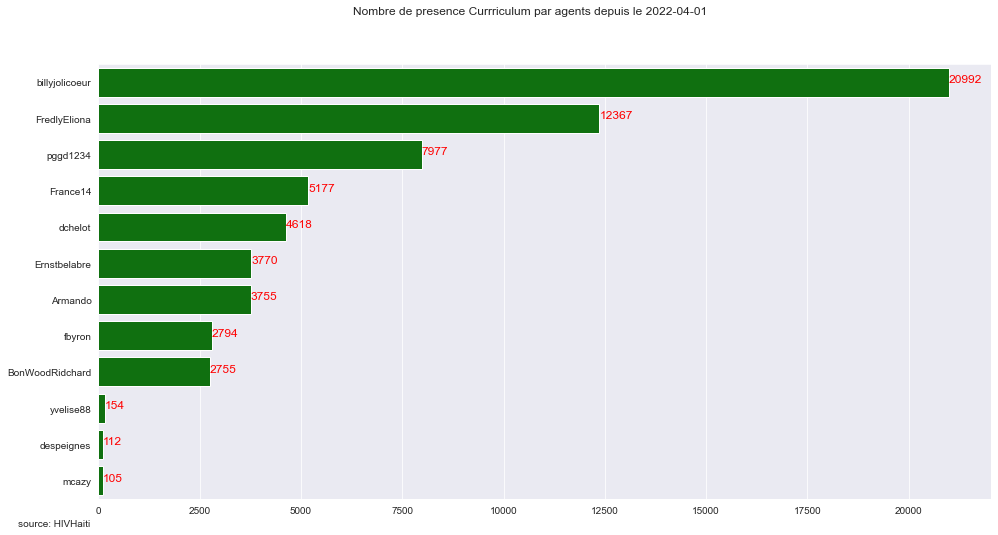

In [12]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nombre_pres",y="username",data=pres_byAgent,color="Green",order=pres_byAgent.sort_values("nombre_pres",ascending=False).username,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de presence Currriculum par agents depuis le {Period.date.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )
    plt.savefig(f"saisie_curriculum",dpi=1000)
except ValueError:
    print(f"no activities where registered")

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Nombre de presence Currriculum par agents pour la semaine du 2022-07-10')

Text(68.25, 0.0, '68')

Text(-80, -20, 'source: HIVHaiti')

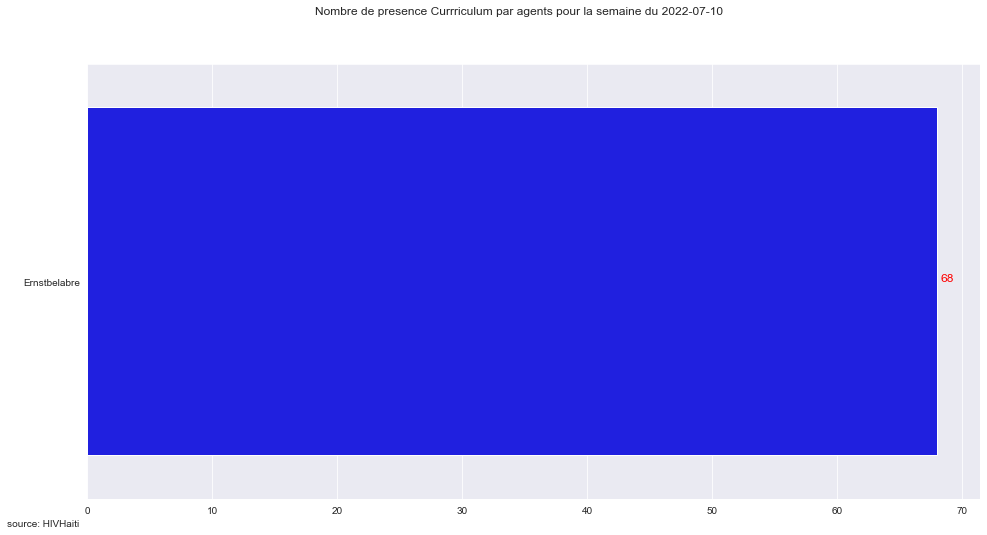

In [13]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nombre_pres",y="username",data=pres_byAgent_week,color="Blue",order=pres_byAgent_week.sort_values("nombre_pres",ascending=False).username,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de presence Currriculum par agents pour la semaine du {Period.week.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )
    plt.savefig(f"saisie_curriculum_week",dpi=1000)
except ValueError:
    print(f"no activities where registered pour cette semaine {Period.week.value}")

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Nombre de presence parenting par agents depuis le 2022-04-01')

Text(547.25, 0.0, '547')

Text(-80, -20, 'source: HIVHaiti')

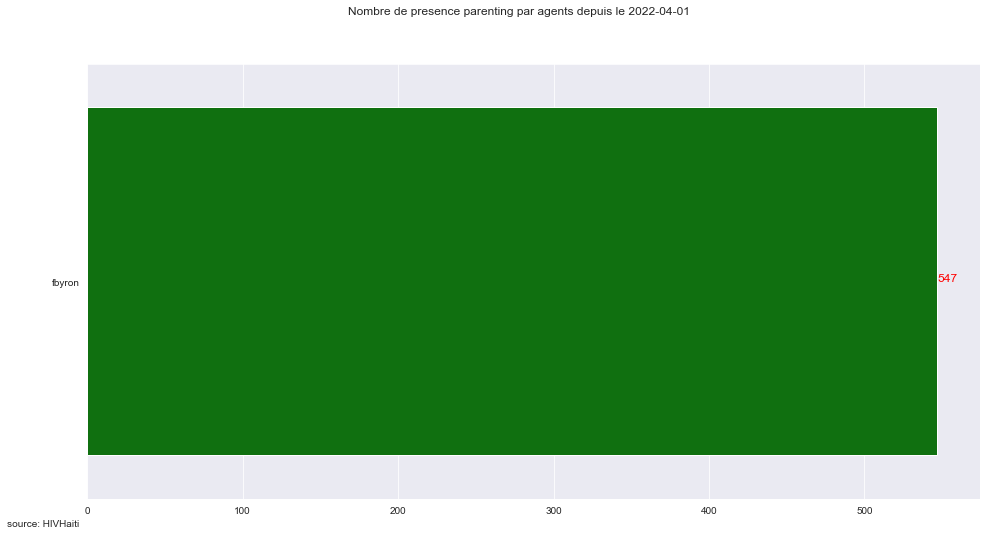

In [14]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nombre_pres",y="username",data=pres_parenting,color="Green",order=pres_parenting.sort_values("nombre_pres",ascending=False).username,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de presence parenting par agents depuis le {Period.date.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))
    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )
    plt.savefig(f"saisie_parenting",dpi=1000)
except ValueError:
    print(f"no activities where registered")

# Validation of the pivot table

In [15]:
def validation_pivot(pt):
    if not pt.empty:
        pt = pt.pivot_table(values='id_patient',index='username',columns='commune',aggfunc='count',fill_value=0,margins=True, margins_name='Total')
    if pt.empty:
        pt =  DataFrame({"resultats":["No data entry"]})
    return pt

# Component 2

In [16]:
options.display.latex.repr = True

#ben_table = ben_byAgent.pivot_table(values='id_patient',index='username',columns='commune',aggfunc='count',fill_value=0,margins=True, margins_name='Total')
ben_table = validation_pivot(ben_byAgent)
ben_table = ben_table.style.highlight_max()
ben_table

print('-----------------------------------------------------------------------------------------------------')

ben_table_week = validation_pivot(ben_byAgent_week)
ben_table_week = ben_table_week.style.highlight_max()
ben_table_week


print('-----------------------------------------------------------------------------------------------------')

#parenting_table = parenting_byAgent.pivot_table(values='id_patient',index='username',columns='commune',aggfunc='count',fill_value=0,margins=True, margins_name='Total')
parenting_table = validation_pivot(parenting_byAgent)
parenting_table = parenting_table.style.highlight_max()
parenting_table

export(ben_table,'ben_table.png')
export(ben_table_week, 'ben_table_week.png')
export(parenting_table,'parenting_table.png')

commune,Cap-Haïtien,Carrefour,Delmas,Desdunes,Dessalines,Grande Saline,Gressier,Kenscoff,La Chapelle,Liancourt,Limonade,Milot,Montrouis,Petite Rivière de l'Artibonite,Plaine-du-Nord,Port-au-Prince,Pétionville,Quartier-Morin,Saint-Marc,Tabarre,Verrettes,Total
username,,,,,,,,,,,,,,,,,,,,,,
Armando,0,0,0,0,0,41,3,0,0,63,0,0,0,0,0,0,0,0,0,0,30,137
BonWoodRidchard,38,9,23,0,0,0,0,7,0,0,0,0,11,32,0,4,0,0,0,27,0,151
Ernstbelabre,0,0,0,0,0,93,28,0,0,0,0,0,0,0,0,0,0,0,0,0,86,207
France14,0,0,0,0,357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,357
FredlyEliona,0,183,0,15,0,41,32,49,98,0,0,27,3,16,0,99,6,0,0,63,48,680
billyjolicoeur,176,26,36,0,0,0,39,234,43,0,50,14,25,26,72,64,163,36,0,25,50,1079
dchelot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,344,0,0,344
despeignes,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
fbyron,34,42,7,41,0,0,0,0,0,0,0,0,0,21,0,5,20,0,0,0,0,170


-----------------------------------------------------------------------------------------------------


commune,Gressier,Total
username,,
Ernstbelabre,17,17
Total,17,17


-----------------------------------------------------------------------------------------------------


commune,Grande Saline,Pétionville,Saint-Marc,Tabarre,Total
username,,,,,
fbyron,8,29,4,21,62
Total,8,29,4,21,62


/usr/local/lib/python3.10/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
objc[12702]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa4c510318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.114/Libraries/libGLESv2.dylib (0x118462d18). One of the two will be used. Which one is undefined.
[0718/131903.123106:INFO:headless_shell.cc(660)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmp54yr9964/temp.png.
objc[12716]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa4c510318) and /Applications/Google Chrome.app/Contents/Framework

# 3 component 

In [17]:
options.display.latex.repr = True

curriculum_result = DataFrame(
    [
        {'Nombre de fille': ben_byAgent.id_patient.count(),
        'Nombre de presence': pres_byAgent.nombre_pres.sum()}
    ]
)
curriculum_result.style.highlight_max()

print('-----------------------------------------------------------------------')

curriculum_result_week = DataFrame(
    [
        {'Nombre de fille': ben_byAgent_week.id_patient.count(),
        'Nombre de presence': pres_byAgent_week.nombre_pres.sum()}
    ]
)
curriculum_result_week.style.highlight_max()


print('-----------------------------------------------------------------------')

parenting_result = DataFrame(
    [
        {'Nombre de fille/parent parenting': parenting_byAgent.id_patient.count(),
        'Nombre de presence': pres_parenting.nombre_pres.sum()}
    ]
)
parenting_result.style.highlight_max()

export(curriculum_result,'curriculum_result.png')
export(curriculum_result_week,'curriculum_result_week.png')
export(parenting_result,'parenting_result.png')

,Nombre de fille,Nombre de presence
0,3538,64576


-----------------------------------------------------------------------


,Nombre de fille,Nombre de presence
0,17,68


-----------------------------------------------------------------------


,Nombre de fille/parent parenting,Nombre de presence
0,62,547


objc[12759]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa4c510318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.114/Libraries/libGLESv2.dylib (0x10efb0d18). One of the two will be used. Which one is undefined.
[0718/131913.619002:INFO:headless_shell.cc(660)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmp8y53q3ks/temp.png.
objc[12769]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa4c510318) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.114/Libraries/libGLESv2.dylib (0x11d115d18). One of the two will be used. Which one is undefined.
[0718/131915.665152:INFO:headless_shell.cc

# Report

In [ ]:
all_report = ExcelWriter(f"rapport_performance.xlsx",engine="openpyxl")
curriculum_result.to_excel(all_report,sheet_name="resultat_curriculum",index=False,na_rep="")
pres_byAgent.to_excel(all_report,sheet_name="presence_agent_curriculum",index=False,na_rep="")
ben_table.to_excel(all_report,sheet_name="ben_communes_curriculum",index=True,na_rep="")
parenting_result.to_excel(all_report,sheet_name="resultat_parenting",index=False,na_rep="")
pres_parenting.to_excel(all_report,sheet_name="pres_agent_parenting",index=False,na_rep="")
parenting_table.to_excel(all_report,sheet_name="ben_communes_parenting",index=True,na_rep="")
all_report.save() 

In [ ]:
week_report = ExcelWriter(f"rapport_pour_la_semaine.xlsx",engine="openpyxl")
curriculum_result_week.to_excel(week_report,sheet_name="resultat_curriculum",index=False,na_rep="")
pres_byAgent_week.to_excel(week_report,sheet_name="presence_agent_curriculum",index=False,na_rep="")
ben_table_week.to_excel(week_report,sheet_name="ben_communes_curriculum",index=True,na_rep="")
week_report.save() 